Import Required Libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

This function will take a list of dictionaries and convert that structure into an initial neural network with He weight initialization.

In [13]:
def init_layers(nn_architecture, seed = 42):
    np.random.seed(seed)
    params_values = {}

    # Take the list of dictionaries and construct a NN with randomly assigned weights and bias vectors.
    # Layers are given small random numbers as their inital state so as not to encounter the breaking symmetry problem if all given the same values and it provides a good enough starting point.
    # Using small values increases the efficiency of the algorithm during the first iterations.
    for i in range(1, len(nn_architecture)):
        layer_input_size = nn_architecture[i-1]["input_nodes"]

        if (i == len(nn_architecture)-1):
            layer_output_size = 10
        else:
            layer_output_size = nn_architecture[i]["input_nodes"]
        
        # Initialize layer node's weights using He Weight Initialization. This is suitable as we are using ReLU activation functions.
        # Source: https://datascience-enthusiast.com/DL/Improving-DeepNeural-Networks-Initialization.html
        # This stage is important as incorrect weight initialization can lead to vanishing/exploding gradients.
        params_values['W' + str(i)] = np.random.randn(
            layer_output_size, layer_input_size) * np.sqrt(2.0 / layer_input_size)
        
        
    return params_values

Sigmoid, ReLU, and Softmax activation functions for both forward popagation and backward (deriative) propagation

In [14]:
# Activation Function - Sigmoid - Forward Propagation
def sigmoid(Z):
    return 1.0/(1.0+np.exp(-Z))

# Activation Function - ReLU - Forward Propagation
def relu(Z):
    return np.maximum(0,Z)

# Activation Function - Softmax - Forward Propagation - Avoids overflow or underflow due to floating point instability.
def softmax(Z):
    e = np.exp(Z - np.max(Z))
    return e / np.sum(e, axis = 0)


# Activation Function - Softmax - Backward Propagation - Avoids overflow or underflow due to floating point instability.
def softmax_backward(Z):
    smax = softmax(Z)
    return smax * (1 - smax)

# Activation Function - Sigmoid - Backward Propagation
def sigmoid_backward(Z):
    sig = sigmoid(Z)
    # return (np.exp(-Z))/((np.exp(-Z)+1)**2)
    return sig * (1-sig)

# Activation Function - ReLU - Backward Propagation
def relu_backward(Z):
    dZ = np.array(Z, copy = True)
    dZ[Z <= 0] = 0
    dZ[Z > 0] = 1
    return dZ

Forward Propagation is split into two functions, single layer step-forward and entire NN step forward.


In [15]:
def single_layer_forward_propagation(A_prev, W_curr, activation="relu"):

    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    elif activation == "softmax":
        activation_func = softmax
    else:
        raise Exception('Non-supported activation function')

    # Compute error.
    Z_curr = np.dot(W_curr, A_prev)
        
    return activation_func(Z_curr), Z_curr

# X - Input Matrix
# Will perform a full forward step propagation and organize all intermdeite values returned from each step forward of a layer.
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    memory["A0"] = A_curr
    
    for idx in range(len(nn_architecture)):
        # Don't evaluate the output layer
        if (idx == len(nn_architecture)-1): continue
        layer_idx = idx + 1
        A_prev = A_curr
        
        # Get current layer's activation function
        activ_function_curr = nn_architecture[layer_idx]["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, activ_function_curr)
        
        memory["A" + str(layer_idx)] = A_curr
        memory["Z" + str(layer_idx)] = Z_curr
    
    # Return A value of the output layer and computed values of all layers.
    return A_curr, memory

Backward Propagation is split into two functions, single layer step-backward and entire NN step backward.

In [16]:
def single_layer_backward_propagation(y, W_curr, Z_curr, A_prev, Y, is_output_layer, error, activation="relu"):
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    elif activation == "softmax":
        backward_activation_func = softmax_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(Z_curr)
    error_cal = None

    # Error of the output layer
    if is_output_layer:
        error_cal = 2 * (y - Y) / y.shape[0] * dZ_curr
    # Error of the hidden layers
    else:
        error_cal = np.dot(W_curr.T, error) * dZ_curr
    
    dW_curr = np.dot(error_cal, A_prev.T)
    return dW_curr, error_cal

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    error = 0
    
    for layer_idx_curr, layer in reversed(list(enumerate(nn_architecture))):
        # Don't calculate the weight's gradient values for the input layer.
        if (layer_idx_curr == 0): continue
        
        layer_idx_prev = layer_idx_curr - 1
        activ_function_curr = layer["activation"]
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr+1)] if layer_idx_curr != len(nn_architecture)-1 else None
        
        is_output_layer = True if layer_idx_curr == len(nn_architecture)-1 else False
        dW_curr, error = single_layer_backward_propagation(
            Y_hat, W_curr, Z_curr, A_prev, Y, is_output_layer, error, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
    
    return grads_values

Stochastic Gradient Descent

In [17]:
# Gradient descent optimization.
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        if (layer_idx == len(nn_architecture)-1): continue
        params_values["W" + str(layer_idx+1)] -= learning_rate * grads_values["dW" + str(layer_idx+1)]

    return params_values

For a dataset, which is a multi-class clasification problem, it is best suited to use a softmax activation function for the output layer as well as cross entropy to compute the loss value for a particular predicted value.

In [18]:
# Loss Function - Calculates categorical cross entropy
# Cross entropy will provide a score for each value passed in. This score represents the distance from the actual value/label.
# As this is logarithmic, small differences are given small scores and large differences are given enormous scores.
# These scores are then used to penalize the probability.

# An alternative, more efficeint function of this idea is scikit-learn's log_loss() function.
def get_metrics(X_test, y_test, params_values, nn_architecture):
    predictions_accuracy = np.array([])
    predictions_cost = np.array([])
    
    for X, y in zip(X_test, y_test):
        output, memory = full_forward_propagation(X, params_values, nn_architecture)
        predictions_accuracy = np.append(predictions_accuracy, np.argmax(output) == np.argmax(y))

        for idx, val in enumerate(y):
            # A very small value of 1e-15 is added to the predicted probability to prevent ever calculating the log of 0. 
            predictions_cost = np.append(predictions_cost, val * np.log(1e-15 + output[idx]))
            
    return np.mean(predictions_accuracy), -np.sum(predictions_cost) / y_test.shape[0]

This will take the target and features and create a mini-batch of the total data based on batch_size.

In [19]:
# Taken from this post: https://stackoverflow.com/a/54647545/10439539
# This will take the target and features and create a mini-batch of the total data based on batch_size.
def iterate_minibatches(inputs, targets, batchsize, seed, shuffle=False):
    np.random.seed(seed)
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0], batchsize):
        end_idx = min(start_idx + batchsize, inputs.shape[0])
        if shuffle:
            excerpt = indices[start_idx:end_idx]
        else:
            excerpt = slice(start_idx, end_idx)
        yield inputs[excerpt], targets[excerpt]

Function to train the NN using the forward and backward propagation functions.

In [20]:
def train(X_train, y_train, X_test, y_test, nn_architecture, batch_size, epochs, learning_rate, seed):
    # Create neural network based on specified architecture with initial weights.
    params_values = init_layers(nn_architecture, seed)
    metrics = [[], []]
    
    # Timer for time metrics.
    start_time = time.time()
    for i in range(epochs):
        for batch in iterate_minibatches(X_train, y_train, batch_size, seed, shuffle=True):
            X_batch, y_batch = batch
            Y_hat, memory = full_forward_propagation(X_batch.T, params_values, nn_architecture)
            
            grads_values = full_backward_propagation(Y_hat, y_batch.T, memory, params_values, nn_architecture)
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)

        accuracy, loss = get_metrics(X_test, y_test, params_values, nn_architecture)
        metrics[0].append(accuracy)
        metrics[1].append(loss)

        print('Epoch: {0}, Total Time Spent: {1:.2f}s, Accuracy: {2:.2f}%, Loss: {3:.3f}'.format(
                i+1, time.time() - start_time, accuracy * 100, loss
            ))
        
    return params_values, metrics

Tuning Learning Rate


Learning Rate: 0.1, NN Architecture: [{'input_nodes': 784, 'activation': 'relu'}, {'input_nodes': 64, 'activation': 'relu'}, {'input_nodes': 10, 'activation': 'softmax'}]
Epoch: 1, Total Time Spent: 20.63s, Accuracy: 84.73%, Loss: 0.454
Epoch: 2, Total Time Spent: 41.26s, Accuracy: 85.06%, Loss: 0.438
Epoch: 3, Total Time Spent: 61.26s, Accuracy: 85.08%, Loss: 0.442
Epoch: 4, Total Time Spent: 82.22s, Accuracy: 85.37%, Loss: 0.434
Epoch: 5, Total Time Spent: 102.54s, Accuracy: 10.00%, Loss: 29.701
Epoch: 6, Total Time Spent: 123.27s, Accuracy: 10.00%, Loss: 30.791
Epoch: 7, Total Time Spent: 143.61s, Accuracy: 10.00%, Loss: 30.783
Epoch: 8, Total Time Spent: 162.52s, Accuracy: 10.00%, Loss: 30.774
Epoch: 9, Total Time Spent: 181.63s, Accuracy: 10.00%, Loss: 30.764
Epoch: 10, Total Time Spent: 199.94s, Accuracy: 10.00%, Loss: 30.752
Epoch: 11, Total Time Spent: 219.11s, Accuracy: 10.00%, Loss: 30.737
Epoch: 12, Total Time Spent: 238.04s, Accuracy: 10.00%, Loss: 30.719
Epoch: 13, Total 

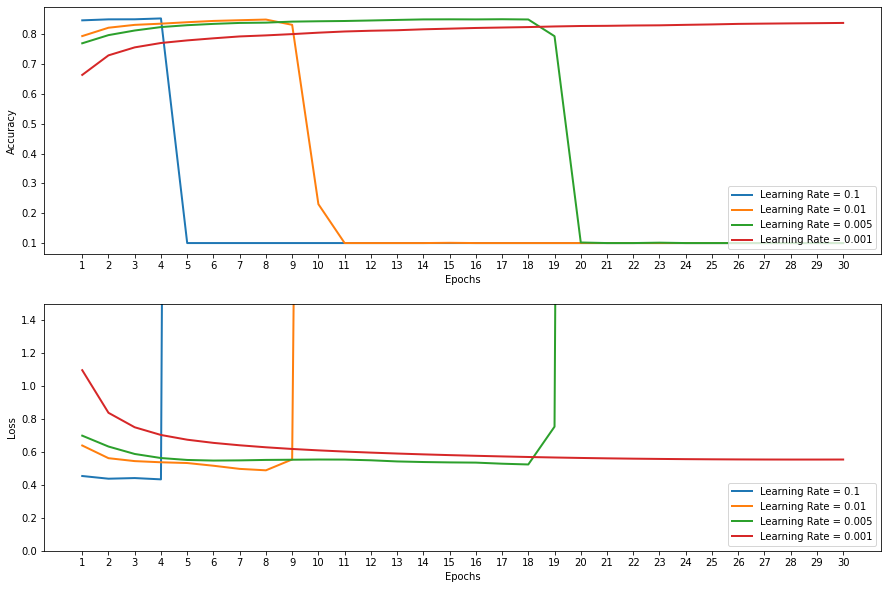

In [20]:
learning_rates = [0.1, 0.01, 0.005, 0.001]

nn_architectures = [[
    {"input_nodes": 784, "activation": "relu"},
    {"input_nodes": 64, "activation": "relu"},
    {"input_nodes": 10, "activation": "softmax"},
]]

df_test = pd.read_csv('./Dataset/fashion-mnist_test.csv')
df_train = pd.read_csv('./Dataset/fashion-mnist_train.csv')

y_train = np.array(df_train['label'].to_numpy())
df_train = df_train.drop('label', axis=1)
X_train = np.array((df_train.to_numpy() / 255).astype('float32'))

y_test = np.array(df_test['label'].to_numpy())
df_test = df_test.drop('label', axis=1)
X_test = np.array((df_test.to_numpy() / 255).astype('float32'))

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

performance = []

for idx, l_rate in enumerate(learning_rates):
    for idx2, nn_arch in enumerate(nn_architectures):
        print('\nLearning Rate: {0}, NN Architecture: {1}'.format(l_rate, nn_arch))
        params_values, metrics_history = train(X_train, y_train, X_test, y_test, nn_arch, 1, 30, l_rate, 42)
        performance.append([l_rate, metrics_history])

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(2, 1)

for idx in range(len(performance)):
    axs[0].plot(np.arange(1, len(performance[idx][1][0])+1), performance[idx][1][0], linewidth=2, label="Learning Rate = {}".format(performance[idx][0]))
    axs[1].plot(np.arange(1, len(performance[idx][1][1])+1), performance[idx][1][1], linewidth=2, label="Learning Rate = {}".format(performance[idx][0]))

axs[1].set_ylim([0, 1])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_xticks(np.arange(1, len(performance[idx][1][0])+1))

axs[1].set_ylim([0, 1.5])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend(loc="lower right")
axs[1].set_xticks(np.arange(1, len(performance[idx][1][0])+1))

plt.show()

Tuning Mini-Batch Size


Mini Batch Size: 8, NN Architecture: [{'input_nodes': 784, 'activation': 'relu'}, {'input_nodes': 64, 'activation': 'relu'}, {'input_nodes': 10, 'activation': 'softmax'}]
Epoch: 1, Total Time Spent: 8.67s, Accuracy: 66.43%, Loss: 1.096
Epoch: 2, Total Time Spent: 17.12s, Accuracy: 73.01%, Loss: 0.838
Epoch: 3, Total Time Spent: 25.57s, Accuracy: 75.65%, Loss: 0.750
Epoch: 4, Total Time Spent: 33.88s, Accuracy: 77.12%, Loss: 0.704
Epoch: 5, Total Time Spent: 42.57s, Accuracy: 78.01%, Loss: 0.676
Epoch: 6, Total Time Spent: 51.36s, Accuracy: 78.57%, Loss: 0.657
Epoch: 7, Total Time Spent: 59.60s, Accuracy: 79.04%, Loss: 0.643
Epoch: 8, Total Time Spent: 67.80s, Accuracy: 79.53%, Loss: 0.631
Epoch: 9, Total Time Spent: 76.00s, Accuracy: 79.94%, Loss: 0.621
Epoch: 10, Total Time Spent: 84.47s, Accuracy: 80.25%, Loss: 0.613
Epoch: 11, Total Time Spent: 92.65s, Accuracy: 80.73%, Loss: 0.606
Epoch: 12, Total Time Spent: 100.87s, Accuracy: 81.00%, Loss: 0.599
Epoch: 13, Total Time Spent: 109.

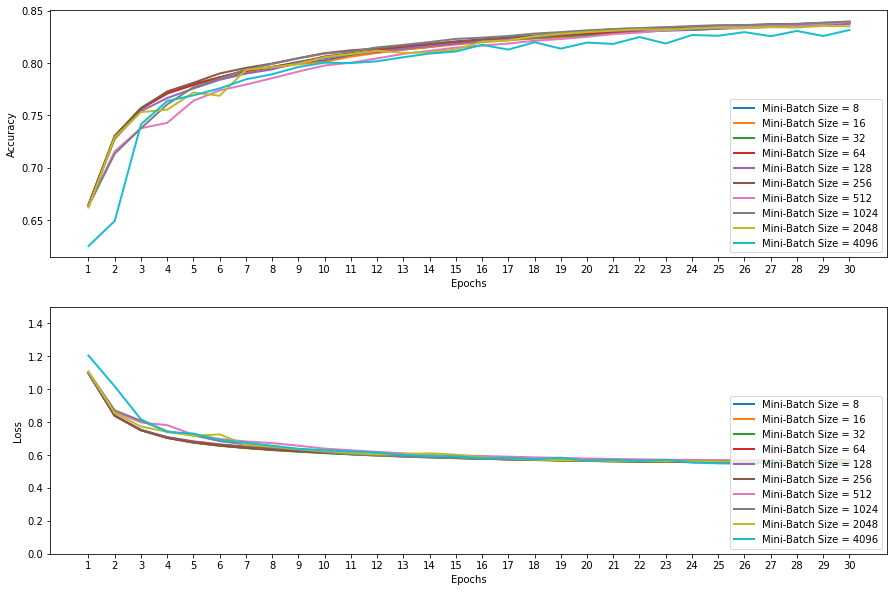

In [21]:
mini_batches = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

nn_architectures = [[
    {"input_nodes": 784, "activation": "relu"},
    {"input_nodes": 64, "activation": "relu"},
    {"input_nodes": 10, "activation": "softmax"},
]]

df_test = pd.read_csv('./Dataset/fashion-mnist_test.csv')
df_train = pd.read_csv('./Dataset/fashion-mnist_train.csv')

y_train = np.array(df_train['label'].to_numpy())
df_train = df_train.drop('label', axis=1)
X_train = np.array((df_train.to_numpy() / 255).astype('float32'))

y_test = np.array(df_test['label'].to_numpy())
df_test = df_test.drop('label', axis=1)
X_test = np.array((df_test.to_numpy() / 255).astype('float32'))

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

performance = []

for idx, m_batch in enumerate(mini_batches):
    for idx2, nn_arch in enumerate(nn_architectures):
        print('\nMini Batch Size: {0}, NN Architecture: {1}'.format(m_batch, nn_arch))
        params_values, metrics_history = train(X_train, y_train, X_test, y_test, nn_arch, m_batch, 30, 0.001, 42)
        performance.append([m_batch, metrics_history])

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(2, 1)

for idx in range(len(performance)):
    axs[0].plot(np.arange(1, len(performance[idx][1][0])+1), performance[idx][1][0], linewidth=2, label="Mini-Batch Size = {}".format(performance[idx][0]))
    axs[1].plot(np.arange(1, len(performance[idx][1][1])+1), performance[idx][1][1], linewidth=2, label="Mini-Batch Size = {}".format(performance[idx][0]))

axs[1].set_ylim([0, 1])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_xticks(np.arange(1, len(performance[idx][1][0])+1))

axs[1].set_ylim([0, 1.5])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend(loc="lower right")
axs[1].set_xticks(np.arange(1, len(performance[idx][1][0])+1))

plt.show()

Tuning NN Architecture


Mini Batch Size: 128, Learning Rate: 0.001, NN Architecture: [{'input_nodes': 784, 'activation': 'relu'}, {'input_nodes': 64, 'activation': 'relu'}, {'input_nodes': 10, 'activation': 'softmax'}]
Epoch: 1, Total Time Spent: 4.60s, Accuracy: 66.39%, Loss: 1.097
Epoch: 2, Total Time Spent: 9.21s, Accuracy: 72.76%, Loss: 0.839
Epoch: 3, Total Time Spent: 13.74s, Accuracy: 75.40%, Loss: 0.753
Epoch: 4, Total Time Spent: 18.21s, Accuracy: 76.65%, Loss: 0.709
Epoch: 5, Total Time Spent: 22.88s, Accuracy: 77.56%, Loss: 0.683
Epoch: 6, Total Time Spent: 27.35s, Accuracy: 78.39%, Loss: 0.665
Epoch: 7, Total Time Spent: 31.78s, Accuracy: 78.98%, Loss: 0.651
Epoch: 8, Total Time Spent: 36.24s, Accuracy: 79.39%, Loss: 0.639
Epoch: 9, Total Time Spent: 40.68s, Accuracy: 80.05%, Loss: 0.629
Epoch: 10, Total Time Spent: 45.19s, Accuracy: 80.47%, Loss: 0.620
Epoch: 11, Total Time Spent: 49.67s, Accuracy: 80.86%, Loss: 0.611
Epoch: 12, Total Time Spent: 54.15s, Accuracy: 81.08%, Loss: 0.604
Epoch: 13, 

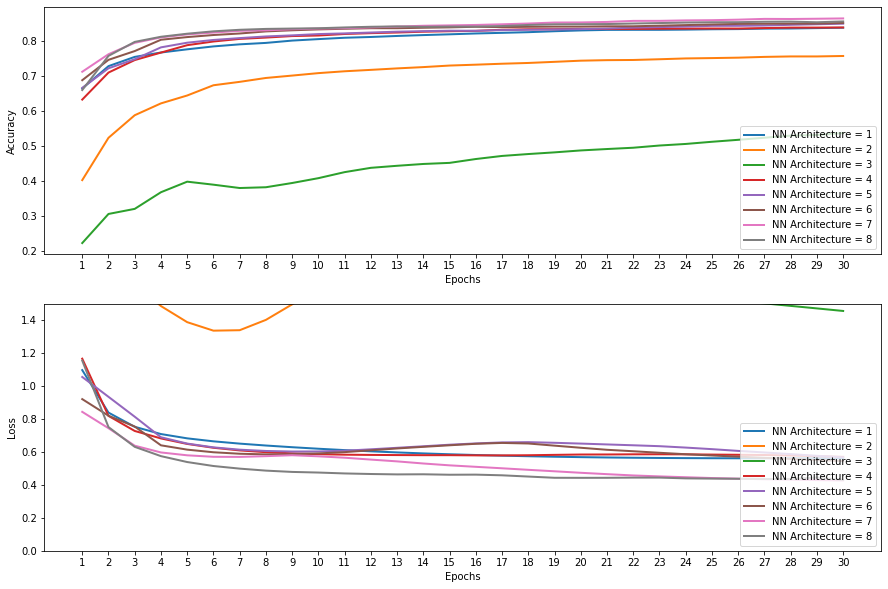

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

nn_architectures = [[
    {"input_nodes": 784, "activation": "relu"},
    {"input_nodes": 64, "activation": "relu"},
    {"input_nodes": 10, "activation": "softmax"},
],[
    {"input_nodes": 784, "activation": "sigmoid"},
    {"input_nodes": 64, "activation": "sigmoid"},
    {"input_nodes": 10, "activation": "softmax"},
],[
    {"input_nodes": 784, "activation": "sigmoid"},
    {"input_nodes": 128, "activation": "sigmoid"},
    {"input_nodes": 64, "activation": "sigmoid"},
    {"input_nodes": 10, "activation": "softmax"},
],[
    {"input_nodes": 784, "activation": "relu"},
    {"input_nodes": 64, "activation": "relu"},
    {"input_nodes": 64, "activation": "relu"},
    {"input_nodes": 10, "activation": "softmax"},
],[
    {"input_nodes": 784, "activation": "relu"},
    {"input_nodes": 128, "activation": "relu"},
    {"input_nodes": 64, "activation": "relu"},
    {"input_nodes": 10, "activation": "softmax"},
],[
    {"input_nodes": 784, "activation": "relu"},
    {"input_nodes": 512, "activation": "relu"},
    {"input_nodes": 64, "activation": "relu"},
    {"input_nodes": 10, "activation": "softmax"},
],[
    {"input_nodes": 784, "activation": "relu"},
    {"input_nodes": 512, "activation": "relu"},
    {"input_nodes": 128, "activation": "relu"},
    {"input_nodes": 64, "activation": "relu"},
    {"input_nodes": 10, "activation": "softmax"},
],[
    {"input_nodes": 784, "activation": "relu"},
    {"input_nodes": 512, "activation": "relu"},
    {"input_nodes": 256, "activation": "relu"},
    {"input_nodes": 128, "activation": "relu"},
    {"input_nodes": 64, "activation": "relu"},
    {"input_nodes": 10, "activation": "softmax"},
]]

df_test = pd.read_csv('./Dataset/fashion-mnist_test.csv')
df_train = pd.read_csv('./Dataset/fashion-mnist_train.csv')

y_train = np.array(df_train['label'].to_numpy())
df_train = df_train.drop('label', axis=1)
X_train = np.array((df_train.to_numpy() / 255).astype('float32'))

y_test = np.array(df_test['label'].to_numpy())
df_test = df_test.drop('label', axis=1)
X_test = np.array((df_test.to_numpy() / 255).astype('float32'))

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

performance = []

for idx, nn_arch in enumerate(nn_architectures):
    print('\nMini Batch Size: {0}, Learning Rate: {1}, NN Architecture: {2}'.format(128, 0.001, nn_arch))
    params_values, metrics_history = train(X_train, y_train, X_test, y_test, nn_arch, 128, 30, 0.001, 42)
    performance.append([nn_arch, metrics_history])

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(2, 1)

for idx in range(len(performance)):
    axs[0].plot(np.arange(1, len(performance[idx][1][0])+1), performance[idx][1][0], linewidth=2, label="NN Architecture = {}".format(idx+1))
    axs[1].plot(np.arange(1, len(performance[idx][1][1])+1), performance[idx][1][1], linewidth=2, label="NN Architecture = {}".format(idx+1))

axs[1].set_ylim([0, 1])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_xticks(np.arange(1, len(performance[idx][1][0])+1))

axs[1].set_ylim([0, 1.5])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend(loc="lower right")
axs[1].set_xticks(np.arange(1, len(performance[idx][1][0])+1))

plt.show()